# Data Cleaning

In [1]:
#load libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from math import e, pi, log, factorial
from scipy.stats import poisson
#import pytorch libraries
import torch
from torch import Tensor

# Load Data


In [2]:
#training data
train_input = pd.read_csv("./wc.csv")
#test data
test = pd.read_csv("./data/test_data.csv")

Teams_target = sorted(list(set(train_input.localTeam)))
#team labels
Teams_main = pd.DataFrame(data = {"Teams" : Teams_target})
Teams = {}
for i in range(len(Teams_main)):
    Teams[Teams_main.Teams[i]] = i

In [3]:
Teams

{'Argentina': 0,
 'Australia': 1,
 'Belgium': 2,
 'Brazil': 3,
 'Colombia': 4,
 'Costa Rica': 5,
 'Croatia': 6,
 'Denmark': 7,
 'England': 8,
 'France': 9,
 'Germany': 10,
 'Iceland': 11,
 'Iran': 12,
 'Japan': 13,
 'Korea Republic': 14,
 'Mexico': 15,
 'Morocco': 16,
 'Nigeria': 17,
 'Panama': 18,
 'Peru': 19,
 'Poland': 20,
 'Portugal': 21,
 'Russia': 22,
 'Saudi Arabia': 23,
 'Senegal': 24,
 'Serbia': 25,
 'Spain': 26,
 'Sweden': 27,
 'Switzerland': 28,
 'Tunisia': 29,
 'Uruguay': 30}

# Function

In [ ]:

#########################################
#########################################Define the Posterior and it's derivatives
#likelihood function
def likelihood(theta, train_input):
    prod = 1
    #collect coefficients
    Delta = theta[0]
    alphas = theta[1:32]
    betas = theta[32:63]

    for i in range(len(train_input)):
        indexH = Teams[train_input.localTeam[i]]
        indexA = Teams[train_input.visitorTeam[i]]
        y_home = float(train_input.localGoals[i])
        y_away = float(train_input.visitorGoals[i])

        mu_home = e ** (Delta + alphas[indexH] - betas[indexA])
        mu_away = e ** (Delta + alphas[indexA] - betas[indexH])

        first_prob = poisson.pmf(y_home, mu_home)
        second_prob = poisson.pmf(y_away, mu_away)

        prod = prod*first_prob*second_prob

    return prod

def posterior(theta, train_input):
    prior = e ** (-0.5 * theta.norm() ** 2)

    return likelihood(theta, train_input) * prior



#simple MAP
#41 parameters, 0 to 41
#train_input is a dataframe
def log_MAP(theta, train_input):
    #collect coefficients
    #Delta = theta[0]
    #alphas = theta[1:21]
    #betas = theta[21:41]
    #calculate regularisor
    regularisor = -0.5 * theta.norm() ** 2
    #second sum
    somme2 = regularisor
    for i in range(len(train_input)):
        indexH = Teams[train_input.localTeam[i]]
        indexA = Teams[train_input.visitorTeam[i]]
        L = -( e ** (theta[0] + theta[1+indexH] - theta[32+indexA]) + e ** (theta[0] + theta[1+indexA] - theta[32+indexH]) ) + float(train_input.localGoals[i]) * (theta[0] + theta[1+indexH] - theta[32+indexA]) + float(train_input.visitorGoals[i]) * (theta[0] + theta[1+indexA] - theta[32+indexH])
        somme2 = somme2 + L

    return(somme2)


def gradient_log_MAP(theta, train_input):
    #collect coefficients
    Delta = theta[0]
    alphas = theta[1:32]
    betas = theta[32:63]
    #grad vector
    gradient = torch.zeros(63,1)   
    #first component with respect to Delta
    somme1 = -Delta
    for i in range(len(train_input)):
        indexH = Teams[train_input.localTeam[i]]
        indexA = Teams[train_input.visitorTeam[i]]
        somme1 = somme1 - e ** (Delta + alphas[indexH] - betas[indexA]) - e ** (Delta + alphas[indexA] - betas[indexH]) + float(train_input.visitorGoals[i])
    gradient[0] = float(somme1)

    #components
    somme2 = 0
    somme3 = 0
    for k in range(31):
        somme2 = -alphas[k]
        somme3 = -betas[k]
        for i in range(len(train_input)):
            indexH = Teams[train_input.localTeam[i]]
            indexA = Teams[train_input.visitorTeam[i]]
            if indexH == k:
                somme2 = somme2 - e ** (Delta + alphas[indexH] - betas[indexA]) + float(train_input.localGoals[i])
                somme3 = somme3 + e ** (Delta + alphas[indexA] - betas[indexH]) - float(train_input.visitorGoals[i])
            if indexA == k:
                somme2 = somme2 - e ** (Delta + alphas[indexA] - betas[indexH]) + float(train_input.visitorGoals[i])
                somme3 = somme3 + e ** (Delta + alphas[indexH] - betas[indexA]) - float(train_input.localGoals[i])

        gradient[1+k] = float(somme2)
        gradient[32+k] = float(somme3)

    return gradient


def Hess_log_MAP(theta, train_input):
    #collect coefficients
    Delta = theta[0]
    alphas = theta[1:32]
    betas = theta[32:63]
    #grad vector
    Hess = np.zeros([63, 63])
    #first component with respect to Delta
    somme1 = -1
    for k in range(len(train_input)):
        indexH = Teams[train_input.localTeam[k]]
        indexA = Teams[train_input.visitorTeam[k]]
        somme1 = somme1 - e ** (Delta + alphas[indexH] - betas[indexA]) - e ** (Delta + alphas[indexA] - betas[indexH])
    Hess[0][0] = float(somme1)

    #2nd components with respect to delta alphai and alphai^2 and betai^2
    somme2 = 0
    somme3 = 0
    somme4 = -1
    somme5 = -1
    for k in range(31):
        somme2 = 0
        somme3 = 0
        somme4 = -1
        somme5 = -1
        for i in range(len(train_input)):
            indexH = Teams[train_input.localTeam[i]]
            indexA = Teams[train_input.visitorTeam[i]]

            if indexH == k:
                somme2 = somme2 - e ** (Delta + alphas[indexH] - betas[indexA])
                somme3 = somme3 - e ** (Delta + alphas[indexA] - betas[indexH])
                somme4 = somme4 - e ** (Delta + alphas[indexH] - betas[indexA])
                somme5 = somme5 - e ** (Delta + alphas[indexA] - betas[indexH])
            if indexA == k:
                somme2 = somme2 - e ** (Delta + alphas[indexA] - betas[indexH])
                somme3 = somme3 - e ** (Delta + alphas[indexH] - betas[indexA])
                somme4 = somme4 - e ** (Delta + alphas[indexA] - betas[indexH])    
                somme5 = somme5 - e ** (Delta + alphas[indexH] - betas[indexA])     


        Hess[0][1 + k] = float(somme2)
        Hess[1 + k][0] = float(somme2)

        Hess[0][32 + k] = float(somme3)
        Hess[32 + k][0] = float(somme3)

        Hess[1 + k][1 + k] = float(somme4)
        Hess[32 + k][32 + k] = float(somme5)




    #6th components with respect to alphai betai
    somme6 = 0
    for k in range(31):
        for l in range(31):
            somme6 = 0
            for i in range(len(train_input)):
                indexH = Teams[train_input.localTeam[i]]
                indexA = Teams[train_input.visitorTeam[i]]

                if indexH == k & indexA == l:
                    somme6 = somme6 + e ** (Delta + alphas[indexH] - betas[indexA])

                if indexH == l & indexA == k:
                    somme6 = somme6 + e ** (Delta + alphas[indexA] - betas[indexH])     

            Hess[1 + k][32 + l] = float(somme6)
            Hess[32 + l][1 + k] = float(somme6)

    return Tensor(Hess)

########################################
######################################## GVA variational approach
########################################




########################################
######################################## Optimisation tools
#minibatch stochastic gradient descent

def SGD_batch(train, log_MAP, gradient_log_MAP, theta = torch.zeros(41,1), lr = 1e-1, nb_epochs = 250):
    #initialisation
    train_input = train
    #initial starting position
    #theta = torch.zeros(41,1)
    criterion = log_MAP
    gradient = gradient_log_MAP

    #number of epochs for training
    #nb_epochs = 250
    n = len(train) #number of samples
    mini_batch_size = n // 20
    sum_loss = 0
    count_of_decrease = 0
    record_loss = np.zeros([nb_epochs])

    #gradient descent
    for e in range(0, nb_epochs):
        sum_loss = 0
        for b in range(0, n, mini_batch_size):
            theta = theta + lr * gradient(theta, train_input[b:b + mini_batch_size].reset_index())
            loss = -criterion(theta, train_input[b:b + mini_batch_size].reset_index())
            sum_loss = sum_loss + loss

        record_loss[e] = loss
        if e > 0 and record_loss[e - 1] < record_loss[e]:
            count_of_decrease += 1
        if count_of_decrease == 5:
            lr = lr * 0.5
            count_of_decrease = 0


    plt.plot(record_loss)
    plt.show()

    return theta, record_loss


########################################
######################################## SAMPLING
def posterior_ratio(theta_proposal, theta_start, train_input):

    #collect coefficients
    Deltaprop = theta_proposal[0]
    alphasprop = theta_proposal[1:21]
    betasprop = theta_proposal[21:41]

    Deltastart = theta_start[0]
    alphasstart = theta_start[1:21]
    betasstart = theta_start[21:41]


    #prior
    prod1 = e ** ( -0.5 * (theta_proposal.norm() ** 2 - theta_start.norm() ** 2))

    #likelihood
    prod = 1
    prod2 = 1
    prod3 = 1
    for i in range(len(train_input)):

        indexH = Teams[train_input.localTeam[i]]
        indexA = Teams[train_input.visitorTeam[i]]
        y_home = float(train_input.localGoals[i])
        y_away = float(train_input.visitorGoals[i])

        mu_homeprop = e ** (Deltaprop + alphasprop[indexH] - betasprop[indexA])
        mu_homestart = e ** (Deltastart + alphasstart[indexH] - betasstart[indexA])
        mu_awayprop = e ** (alphasprop[indexA] - betasprop[indexH])
        mu_awaystart = e ** (alphasstart[indexA] - betasstart[indexH])


        ratio1 = (mu_homeprop/mu_homestart) ** y_home
        ratio2 = (mu_awayprop/mu_awaystart) ** y_home

        prod = prod * ratio1 * ratio2

    return prod1 * prod

def posterior_ratio_log(theta_proposal, theta_start, train_input):
    
    val = log_MAP(theta_proposal, train_input) - log_MAP(theta_start, train_input)
    
    return e ** val
    
    
    
def MH_RW_tuned(n, theta0, train_input, lamda, batch_size):
    #for this algorithm, we should start from a relatively small, negative value of lambda
    #convert everything from Tensor to numpy
    theta0 = theta0.view(-1)
    #d = dimension of theta
    d = len(theta0)
    Chain = torch.zeros([batch_size + 1, d])
    Chain[0] = theta0
    Ratio = np.zeros([batch_size + 1])
    Ratio[0] = 0
    C = 0
    lamda_final = lamda
    theta_start = theta0

    #batch loop to find a good lamda
    while C/batch_size < 0.1 or C/batch_size > 0.5:
        C = 0
        for i in range(batch_size):
            theta_proposal = theta_start + Tensor(np.random.uniform(-1,1,d)*lamda_final)
            #rejection/acceptance
            ratio = posterior_ratio_log(theta_proposal, theta_start, train_input)
            p = min(1, ratio)
            #rejection step
            bern = np.random.binomial(1,p,1)
            if bern == 1:
                theta_start = theta_proposal
                C = C + 1



            Chain[i+1] = theta_start
            Ratio[i+1] = ratio    
            lamda_final = lamda_final + 0.00001

    print(C/batch_size)

    #official loop
    #reinitialise everything
    Chain = np.zeros([n+1,d])
    Chain[0] = theta0
    Ratio = np.zeros([n+1])
    Ratio[0] = 0
    C = 0
    lamda_final = lamda
    theta_start = theta0

    for i in range(n):
        theta_proposal = theta_start + Tensor(np.random.uniform(-1,1,d)*lamda_final)
        #rejection/acceptance
        ratio = posterior_ratio_log(theta_proposal, theta_start, train_input)
        p = min(1,ratio)

        #rejection step
        bern = np.random.binomial(1,p,1)
        if bern == 1:
            theta_start = theta_proposal
            C = C + 1
        Chain[i+1] = theta_start
        Ratio[i+1] = ratio

    return Chain, np.mean(Ratio), C/n


########################################
######################################## Prediction tools
def Laplace_sample(mu, covariance, nb_sample1, nb_sample2):

    ####step 1: generate nb_sample samples of theta
    theta_samples = Tensor(np.random.multivariate_normal(mu.view(-1), covariance, nb_sample1))


    ####step 2: for each of the 380 needed predictions, generate 100 samples from each of the 1000
    #samples of theta
    ###initialisation of storage matrix and prediction variables
    Samples_storage = torch.zeros(31, 31, 1, 2)

    #calculate this matrix

    for i in range(31):
        for j in range(31):
            if j != i:
                for k in range(nb_sample1):
                    #parameters
                    thetak = theta_samples[k]
                    delta = thetak[0]
                    alphai = thetak[1 + i]
                    alphaj = thetak[1 + j]
                    betai = thetak[32 + i]
                    betaj = thetak[32 + j]
                    mu_ij_home = e ** (delta + alphai - betaj)
                    mu_ij_away = e ** (alphaj - betai)

                    team1 = sum(np.random.poisson(mu_ij_home, nb_sample2))
                    team2 = sum(np.random.poisson(mu_ij_away, nb_sample2))


                    Samples_storage[i][j] = Samples_storage[i][j] + Tensor([float(team1), float(team2)])

    Samples_storage = Samples_storage / (nb_sample1 * nb_sample2)
    return Samples_storage


def chain_predictor(theta_samples, nb_sample1, nb_sample2):

    ####step 1: for each of the 380 needed predictions, generate 100 samples from each of the 1000
    #samples of theta
    ###initialisation of storage matrix and prediction variables
    Samples_storage = torch.zeros(20, 20, 1, 2)

    #calculate this matrix

    for i in range(20):
        for j in range(20):
            if j != i:
                for k in range(nb_sample1):
                    #parameters
                    thetak = theta_samples[k]
                    delta = thetak[0]
                    alphai = thetak[1 + i]
                    alphaj = thetak[1 + j]
                    betai = thetak[21 + i]
                    betaj = thetak[21 + j]
                    mu_ij_home = e ** (delta + alphai - betaj)
                    mu_ij_away = e ** (alphaj - betai)

                    team1 = sum(np.random.poisson(mu_ij_home, nb_sample2))
                    team2 = sum(np.
                                random.poisson(mu_ij_away, nb_sample2))


                    Samples_storage[i][j] = Samples_storage[i][j] + Tensor([float(team1), float(team2)])

    Samples_storage = Samples_storage / (nb_sample1 * nb_sample2)
    return Samples_storage

########################################
######################################## GVA
def ELBO(data, mu_n, L_n):
    #data is a tensor storing the thetas
    #mu_n, L_n initialised at some points
    #let's say the variance covariance matrix is the identity
    
    l = 100
    d = len(mu_n)
    
    
    e_L = Tensor(scipy.linalg.expm(L_n.numpy()))
    
    somme = + d/2 * log(2 * pi * e) + np.trace(L_n)
    

    for i in range(l):
        eta = Tensor(d,1).normal_(0,1)
        Eeta = e_L.mm(eta)
        somme = somme + log_MAP(Eeta + mu_n, data)
    somme = -somme/l
    
    return(somme)

def gradmu_ELBO(data, mu_n, L_n):
    
    
    l = 100
    d = len(mu_n)
    
    
    e_L = Tensor(scipy.linalg.expm(L_n.numpy()))
    
    somme = 0
    

    for i in range(l):
        eta = Tensor(d,1).normal_(0,1)
        Eeta = e_L.mm(eta)
        somme = somme + gradient_log_MAP(Eeta + mu_n, data)
    somme = -somme/l
    
    
    return(somme)

def gradL_ELBO1(data, mu_n, L_n):
    
    l = 100
    d = len(mu_n)
    
    somme = torch.eye(d)

    e_2L = Tensor(scipy.linalg.expm(2 * L_n.numpy()))
    e_L = Tensor(scipy.linalg.expm(L_n.numpy()))
    
    for i in range(l):
        eta = Tensor(d,1).normal_(0,1)
        Eeta = e_L.mm(eta)
        somme = somme + Tensor(Hess_log_MAP(mu_n + Eeta, train_input))        
    somme = e_2L.mm(somme / l)
    somme = -0.5 * (somme + somme.t())
    somme = somme + torch.eye(d)
    
    return(somme)

def gradL_ELBO2(data, mu_n, L_n):
    
    l = 100
    d = len(mu_n)
    
    somme = torch.eye(d)

    e_L = Tensor(scipy.linalg.expm(L_n.numpy()))
    
    for i in range(l):
        eta = Tensor(d,1).normal_(0,1)
        Eeta = e_L.mm(eta)
        somme = somme + Tensor(Eeta.t().mm(gradient_log_MAP(mu_n + Eeta, train_input)))        
    somme = somme / l
    somme = -0.5 * (somme + somme.t())
    somme = somme + torch.eye(d)
    
    return(somme)

def GVA_HESS(initial_vals, data, lr, plot_yes = True):
    #initialisation
    #d = dimension of mu
    #l = length of data
    l = 100
    mu_n = initial_vals[0]
    L_n = initial_vals[1]
    d = len(mu_n)
    nb_epochs = 100
    energy = np.zeros([100])
    #print("Target", mu_0, varcov_matrix)
    count_of_decrease = 0
    
    
    for k in range(nb_epochs):
        
        gradL = gradL_ELBO1(data, mu_n, L_n)
        gradmu = gradmu_ELBO(data, mu_n, L_n)
        energy[k] = ELBO(data, mu_n, L_n)
        
        if energy[k] < energy[k - 1] and k > 0:
            count_of_decrease += 1
            
        
        if count_of_decrease > 4:
            count_of_decrease = 0
            lr = lr * 0.5

        #update
        mu_n = mu_n + lr * gradmu
        L_n = L_n + lr * gradL

    if plot_yes:
        plt.plot(energy)
        plt.show()

    return((mu_n - mu_0).norm(), (Tensor(scipy.linalg.expm(L_n.numpy())).pow(2) - varcov_matrix).norm(p = 50))

def GVA_grad(initial_vals, data, lr, plot_yes = True):
    #initialisation
    #d = dimension of mu
    #l = length of data
    l = 100
    mu_n = initial_vals[0]
    L_n = initial_vals[1]
    d = len(mu_n)
    nb_epochs = 100
    energy = np.zeros([100])
    #print("Target", mu_0, varcov_matrix)
    count_of_decrease = 0
    
    
    for k in range(nb_epochs):
        
        gradL = gradL_ELBO2(data, mu_n, L_n)
        gradmu = gradmu_ELBO(data, mu_n, L_n)
        energy[k] = ELBO(data, mu_n, L_n)
        
        if energy[k] < energy[k - 1] and k > 0:
            count_of_decrease += 1
            
        
        if count_of_decrease > 4:
            count_of_decrease = 0
            lr = lr * 0.5

        #update
        mu_n = mu_n + lr * gradmu
        L_n = L_n + lr * gradL

    if plot_yes:
        plt.plot(energy)
        plt.show()

    return mu_n, L_n



In [ ]:
print(len(set(train_input.localTeam)))
print(len(train_input))

In [ ]:
print("train:", len(train_input), "validation:", len(validation), "test:", len(test))

In [ ]:
print("division of modelling data train:validation","83% : 17%")

## Gaussian Prior


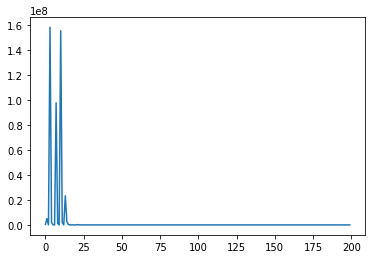

In [58]:
theta, record_loss1 = SGD_batch(train_input, log_MAP, gradient_log_MAP, theta = torch.zeros(63,1), nb_epochs = 200)

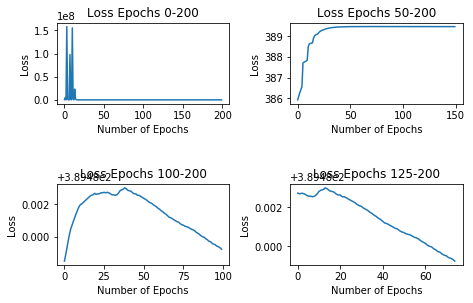

In [59]:
fig = plt.figure()

plt.subplot(221)
plt.plot(record_loss1)
plt.title('Loss Epochs 0-200')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')

plt.subplot(222)
plt.plot(record_loss1[50:])
plt.title('Loss Epochs 50-200')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')

plt.subplot(223)
plt.plot(record_loss1[100:])
plt.title('Loss Epochs 100-200')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')

plt.subplot(224)
plt.plot(record_loss1[125:])
plt.title('Loss Epochs 125-200')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.01, right=0.95, hspace=1,
                    wspace=0.35)
plt.savefig('Laplace_20_loss.png', dpi=fig.dpi, bbox_inches= 'tight', pad_inches=0.1)
plt.show()

In [60]:
hessian = Hess_log_MAP(theta, train_input)

In [61]:
covariance= -hessian.inverse()

In [68]:
mu


-7.2919
 3.4967
 2.9060
 3.1637
 3.6702
 3.3785
 3.6420
 3.2637
 3.0273
 3.6127
 3.5278
 3.5932
 2.6900
 3.1796
 3.7240
 3.8472
 3.8618
 1.8068
 2.3667
 2.6016
 3.1187
 3.3481
 3.5291
 3.0631
 3.2922
 2.1046
 3.1775
 3.1443
 3.5520
 2.9796
 3.2363
 3.4134
-3.5685
-2.7392
-2.9809
-3.6913
-3.6017
-3.4421
-3.2867
-3.3408
-3.2076
-3.6590
-3.6120
-2.7021
-2.4034
-3.3141
-3.7513
-3.6404
-2.4163
-2.6067
-3.0703
-3.0609
-3.2410
-3.4539
-3.2619
-3.2482
-2.4735
-3.2238
-3.4026
-3.5532
-2.7850
-3.1211
-3.4592
[torch.FloatTensor of size 63x1]

In [63]:
mu = theta

In [66]:
scores = Laplace_sample(mu, covariance, 2000, 1000)

/Users/harrisonzhu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:332: RuntimeWarning: covariance is not positive-semidefinite.


In [67]:
scores


(0 ,0 ,.,.) = 
     0.0000     0.0000

(0 ,1 ,.,.) = 
     0.3540   669.7050

(0 ,2 ,.,.) = 
     0.4523   853.5912
   ...

(0 ,28,.,.) = 
     0.3728   708.1600

(0 ,29,.,.) = 
     0.5221   931.1096

(0 ,30,.,.) = 
     0.7222  1084.7003
     ⋮ 

(1 ,0 ,.,.) = 
     0.4570   519.5352

(1 ,1 ,.,.) = 
     0.0000     0.0000

(1 ,2 ,.,.) = 
     0.2596   381.6429
   ...

(1 ,28,.,.) = 
     0.2121   313.8004

(1 ,29,.,.) = 
     0.2970   409.5161

(1 ,30,.,.) = 
     0.4114   479.8777
     ⋮ 

(2 ,0 ,.,.) = 
     0.5819   664.6454

(2 ,1 ,.,.) = 
     0.2597   382.8292

(2 ,2 ,.,.) = 
     0.0000     0.0000
   ...

(2 ,28,.,.) = 
     0.2703   401.3106

(2 ,29,.,.) = 
     0.3790   528.2385

(2 ,30,.,.) = 
     0.5237   613.4891
...   
     ⋮ 

(28,0 ,.,.) = 
     0.4830   545.5732

(28,1 ,.,.) = 
     0.2138   311.1922

(28,2 ,.,.) = 
     0.2733   396.0813
   ...

(28,28,.,.) = 
     0.0000     0.0000

(28,29,.,.) = 
     0.3130   430.0218

(28,30,.,.) = 
     0.4336   502.5666
     

In [ ]:
scores = scores.view(32,32,2)
scores_mat = scores[0]
for i in range(1, 32):
    scores_mat = torch.cat((scores_mat, scores.view(32,32,2)[i]), 1)



In [ ]:
#predict score function
def results(hometeam, awayteam):
    #hometeam, awayteam as strings
    indexh = 2*Teams[hometeam]
    indexa = Teams[awayteam]
    
    homegoal = scores_mat[indexa, indexh]
    awaygoal = scores_mat[indexa, indexh + 1]
    
    return hometeam + ":" + '{:0.2f}'.format(homegoal) + " " + awayteam + ":" + '{:0.2f}'.format(awaygoal)

In [ ]:
print(results("Sweden","Korea Republic"))
print(results("Korea Republic", "Sweden"))

In [ ]:
#save as csv
np.savetxt("scores_laplace.csv", scores_mat.numpy(), delimiter=",")

In [ ]:
theta_samples = Tensor(np.random.multivariate_normal(mu.view(-1), covariance, 10000))

In [ ]:
alpha1 = theta_samples[:,1]
alpha2 = theta_samples[:,2]
beta1 = theta_samples[:,21]
beta2 = theta_samples[:,22]

# plot with various axes scales
num_bins = 100
plt.figure(1)

# alpha1
plt.subplot(221)
n, bins, patches = plt.hist(alpha1, num_bins, facecolor='blue', alpha=0.5)
plt.title('alpha1')
plt.grid(True)


# alpha2
plt.subplot(222)
n, bins, patches = plt.hist(alpha2, num_bins, facecolor='blue', alpha=0.5)
plt.title('alpha2')
plt.grid(True)


# beta1
plt.subplot(223)
n, bins, patches = plt.hist(beta1, num_bins, facecolor='blue', alpha=0.5)
plt.title('beta1')
plt.grid(True)

# beta2
plt.subplot(224)
n, bins, patches = plt.hist(beta2, num_bins, facecolor='blue', alpha=0.5)
plt.title('beta2')
plt.grid(True)


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.4)

plt.show()

In [ ]:
plt.plot(alpha1.numpy(), beta1.numpy(),'.')
plt.show()

In [ ]:
np.savetxt("thetas.csv", mu.numpy(), delimiter=",")

# Markov Chain Monte Carlo Method

In [78]:
np.save('chain_MH2.npy', chain)
np.save('results_MH3_removeburnout.npy', scores_sampling)
#np.load('chain_MH1.npy')

In [60]:
theta = torch.ones(41)
chain, mean_ratio, acceptance = MH_RW_tuned(8000, theta, train_input, -0.001, 800)

0.4525


In [79]:
scores_sampling = chain_predictor(chain[2000:], 6000, 1000)

In [62]:
# real vs barca
P = np.zeros([len(chain),2])

for i in range(1000, len(chain)):
    delta = chain[i][1]
    alpha3 = chain[i][1 + 3]
    alpha15 = chain[i][1 + 15]
    beta3 = chain[i][21 + 3]
    beta15 = chain[i][21 + 15]

    mu_ij_home = e ** (delta + alpha3 - beta15)
    mu_ij_away = e ** (alpha15 - beta3)

    team1 = mu_ij_home
    team2 = mu_ij_away
    
    P[i][0] = team1
    P[i][1] = team2

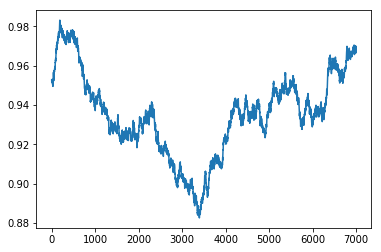

In [63]:
plt.plot(P[1000:,1])

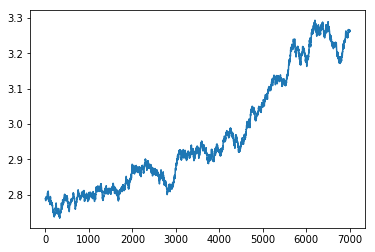

In [64]:
plt.plot(P[1000:,0])

In [ ]:
scores_sampling = scores.view(20,20,2)
scores_sampling_mat = scores[0]
for i in range(1, 20):
    scores_sampling_mat = torch.cat((scores_sampling_mat, scores_sampling.view(20,20,2)[i]), 1)

#save as csv
np.savetxt("scores_M.csv", scores_sampling_mat.numpy(), delimiter=",")

In [70]:
theta_samples_mc = chain

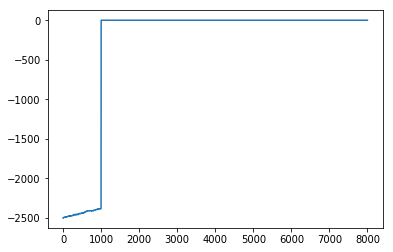

In [67]:
log_MAP(Tensor(chain[0,:]), train_input)
values = np.zeros([8001])

for i in range(1000):
    values[i] = log_MAP(Tensor(chain[i,:]), train_input)
    
plt.plot(values)

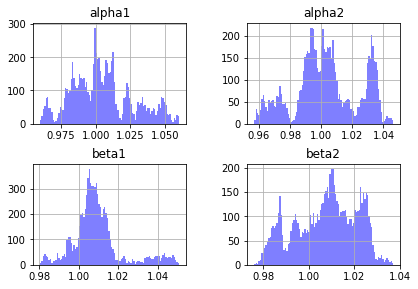

In [71]:
alpha1_mc = theta_samples_mc[:,1]
alpha2_mc = theta_samples_mc[:,2]
beta1_mc = theta_samples_mc[:,21]
beta2_mc = theta_samples_mc[:,22]

# plot with various axes scales
num_bins = 100
plt.figure(1)

# alpha1
plt.subplot(221)
n, bins, patches = plt.hist(alpha1_mc, num_bins, facecolor='blue', alpha=0.5)
plt.title('alpha1')
plt.grid(True)


# alpha2
plt.subplot(222)
n, bins, patches = plt.hist(alpha2_mc, num_bins, facecolor='blue', alpha=0.5)
plt.title('alpha2')
plt.grid(True)


# beta1
plt.subplot(223)
n, bins, patches = plt.hist(beta1_mc, num_bins, facecolor='blue', alpha=0.5)
plt.title('beta1')
plt.grid(True)

# beta2
plt.subplot(224)
n, bins, patches = plt.hist(beta2_mc, num_bins, facecolor='blue', alpha=0.5)
plt.title('beta2')
plt.grid(True)


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.4)

plt.show()

In [73]:
plt.plot(alpha1_mc.numpy(), beta1_mc.numpy(), '.')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [80]:
scores_sampling


(0 ,0 ,.,.) = 
  0.0000  0.0000

(0 ,1 ,.,.) = 
  1.9236  0.9952

(0 ,2 ,.,.) = 
  1.7723  1.0167

(0 ,3 ,.,.) = 
  1.7387  1.1171

(0 ,4 ,.,.) = 
  1.9213  0.9579

(0 ,5 ,.,.) = 
  2.0180  0.9944

(0 ,6 ,.,.) = 
  1.9758  0.9446

(0 ,7 ,.,.) = 
  1.9675  0.9568

(0 ,8 ,.,.) = 
  1.9429  0.9627

(0 ,9 ,.,.) = 
  2.1073  0.9435

(0 ,10,.,.) = 
  1.9913  0.9795

(0 ,11,.,.) = 
  1.9244  0.9678

(0 ,12,.,.) = 
  1.9540  0.9824

(0 ,13,.,.) = 
  1.9612  0.9877

(0 ,14,.,.) = 
  1.9398  0.9385

(0 ,15,.,.) = 
  1.8856  1.0305

(0 ,16,.,.) = 
  2.0369  1.0213

(0 ,17,.,.) = 
  1.9197  1.0051

(0 ,18,.,.) = 
  2.1038  0.9669

(0 ,19,.,.) = 
  1.9072  0.9410

(1 ,0 ,.,.) = 
  1.9269  0.9945

(1 ,1 ,.,.) = 
  0.0000  0.0000

(1 ,2 ,.,.) = 
  1.7761  1.0159

(1 ,3 ,.,.) = 
  1.7418  1.1165

(1 ,4 ,.,.) = 
  1.9225  0.9570

(1 ,5 ,.,.) = 
  2.0212  0.9937

(1 ,6 ,.,.) = 
  1.9790  0.9446

(1 ,7 ,.,.) = 
  1.9704  0.9562

(1 ,8 ,.,.) = 
  1.9438  0.9616

(1 ,9 ,.,.) = 
  2.1083  0.9426

(1 ,10,.,